<a href="https://colab.research.google.com/github/Masakida0514/PytorchStudy/blob/main/Softmax_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Softmax回帰

In [1]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

import numpy as np

np.random.seed(514)

## ロジスティック回帰

### 1. Sigmoid
$$
    \sigma({\bf x}) = \frac{1}{1 + \exp(-{\bf x})} = \frac{\exp({\bf x})}{1 + \exp({\bf x})}
$$

In [2]:
def sigmoid(x):
    # 単純な実装
    # return 1 / (1 + np.exp(-x))
    # expのoverflow対策
    # x >=0 のとき sigmoid(x) = 1 / (1 + exp(-x))
    # x < 0 のとき sigmoid(x) = exp(x) / (1 + exp(x))
    return np.exp(np.minimum(x, 0)) / (1 + np.exp(- np.abs(x)))

### 2 目的関数（2クラス交差エントロピー誤差関数）

$$ E ({\bf x}, {\bf y}; {\bf W}, {\bf b} ) =  -\frac{1}{N}\sum^N_{i=1} \left[ {\bf y}_i \log {\bf \hat{y}}_i ({\bf x}_i; {\bf W}, {\bf b}) + (1 - {\bf y}_i) \log \{ 1 - {\bf \hat{y}}_i ({\bf x}_i; {\bf W}, {\bf b}) \}\right] $$

#### 2.1 モデルの推論
$$
    {\bf \hat{y}}_i = \sigma({\bf W} {\bf x}_i + {\bf b})
$$

#### 2.2 モデルの学習
\begin{align*}
    \delta_i &= {\bf \hat{y}}_i - {\bf y}_i \\
    \nabla_{\bf W} E &= \frac{1}{N}\sum^N_{i=1}\delta_i {\bf x}^{\mathrm{T}}_i \\
    \nabla_{\bf b} E &= \frac{1}{N}\sum^N_{i=1}\delta_i  \\
    {\bf W} &\leftarrow {\bf W} - \epsilon \nabla_{\bf W} E \\
    {\bf b} &\leftarrow {\bf b} - \epsilon \nabla_{\bf b} E \\
\end{align*}

※log関数の定義：log(0)は定義出来ない為、np.clipを用いて実装

clipping : 設定した最小値未満の場合は最小値に、最大値より上の場合最大値に変換すること

In [3]:
def np_log(x):
    return np.log(np.clip(a=x, a_min=1e-10, a_max=1e+10))

## ソフトマックス回帰

### 1. ソフトマックス関数
$$
    \mathrm{softmax}({\bf x})_k = \frac{\exp({\bf x}_k)}{\sum^K_{k'=1} \exp({\bf x}_{k'})} \hspace{10mm} \text{for} \, k=1,\ldots, K
$$

In [4]:
def softmax(x):
    x -= x.max(axis=1, keepdims=True)
    x_exp = np.exp(x)
    return x_exp / np.sum(x_exp, axis=1, keepdims=True)

### 2. データセットの設定と重みの定義

In [5]:
(x_mnist_1, y_mnist_1), (x_mnist_2, y_mnist_2) = mnist.load_data()

x_mnist = np.r_[x_mnist_1, x_mnist_2]
y_mnist = np.r_[y_mnist_1, y_mnist_2]

x_mnist = x_mnist.astype('float32') / 255.
y_mnist = np.eye(N=10)[y_mnist.astype('int32').flatten()]

x_mnist=x_mnist.reshape(x_mnist.shape[0],-1)

x_train_mnist, x_test_mnist, y_train_mnist, y_test_mnist = train_test_split(x_mnist, y_mnist, test_size=10000)
x_train_mnist, x_valid_mnist, y_train_mnist, y_valid_mnist = train_test_split(x_train_mnist, y_train_mnist, test_size=10000)

In [6]:
# 重み (入力の次元数: 784, 出力の次元数: 10)
# 初期値の理論は今回は無し
W_mnist = np.random.uniform(low=-0.08, high=0.08, size=(784, 10)).astype('float32')
b_mnist = np.zeros(shape=(10,)).astype('float32')

### 3. train関数とvalid関数

#### 3.1. 目的関数（多クラス交差エントロピー誤差関数）

$$ E ({\bf x}, {\bf y}; {\bf W}, {\bf b} ) =  -\frac{1}{N}\sum^N_{i=1} \sum^K_{k=1} {\bf y}_{i, k} \log {\bf \hat{y}}_{i, k} ({\bf x}_i; {\bf W}, {\bf b}) $$

#### 3.2. モデルの推論
$$
    {\bf \hat{y}}_i = \mathrm{softmax}({\bf W}{\bf x}_i + {\bf b})
$$

#### 3.3. モデルの学習
\begin{align*}
    \delta_i &= {\bf \hat{y}}_i - {\bf y}_i \\
    \nabla_{\bf W} E &= \frac{1}{N}\sum^N_{i=1}\delta_i {\bf x}^{\mathrm{T}}_i \\
    \nabla_{\bf b} E &= \frac{1}{N}\sum^N_{i=1}\delta_i  \\
    {\bf W} &\leftarrow {\bf W} - \epsilon \nabla_{\bf W} E \\
    {\bf b} &\leftarrow {\bf b} - \epsilon \nabla_{\bf b} E \\
\end{align*}

In [7]:
def train_mnist(x, y, eps=1.0):
    global W_mnist, b_mnist
    
    batch_size = x.shape[0]
    
    # 予測
    y_hat = softmax(np.matmul(x, W_mnist) + b_mnist) # shape: (batch_size, 出力の次元数)
    
    # 目的関数の評価
    cost = (- y * np_log(y_hat)).sum(axis=1).mean()
    delta = y_hat - y
    
    # パラメータの更新
    dW = np.matmul(x.T, delta) / batch_size
    db = np.matmul(np.ones(shape=(batch_size,)), delta) / batch_size
    W_mnist -= eps * dW
    b_mnist -= eps * db

    return cost

def valid_mnist(x, y):
    y_hat = softmax(np.matmul(x, W_mnist) + b_mnist)
    cost = (- y * np_log(y_hat)).sum(axis=1).mean()
    
    return cost, y_hat

### 4. 学習

In [8]:
for epoch in range(100):
    x_train_mnist, y_train_mnist = shuffle(x_train_mnist, y_train_mnist)
    cost = train_mnist(x_train_mnist, y_train_mnist)
    cost, y_pred = valid_mnist(x_valid_mnist, y_valid_mnist)
    if epoch % 10 == 9 or epoch == 0:
        print('EPOCH: {}, Valid Cost: {:.3f}, Valid Accuracy: {:.3f}'.format(
            epoch + 1,
            cost,
            accuracy_score(y_valid_mnist.argmax(axis=1), y_pred.argmax(axis=1))
        ))

EPOCH: 1, Valid Cost: 1.757, Valid Accuracy: 0.464
EPOCH: 10, Valid Cost: 0.964, Valid Accuracy: 0.725
EPOCH: 20, Valid Cost: 0.578, Valid Accuracy: 0.817
EPOCH: 30, Valid Cost: 0.482, Valid Accuracy: 0.854
EPOCH: 40, Valid Cost: 0.410, Valid Accuracy: 0.882
EPOCH: 50, Valid Cost: 0.392, Valid Accuracy: 0.890
EPOCH: 60, Valid Cost: 0.380, Valid Accuracy: 0.893
EPOCH: 70, Valid Cost: 0.371, Valid Accuracy: 0.896
EPOCH: 80, Valid Cost: 0.363, Valid Accuracy: 0.899
EPOCH: 90, Valid Cost: 0.357, Valid Accuracy: 0.901
EPOCH: 100, Valid Cost: 0.352, Valid Accuracy: 0.902


# テスト

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
def check_mnist(i, pred):
  plt.imshow(x_test_mnist[i].reshape(28,28), cmap = 'gray')
  selected = pred[i]
  true = y_test_mnist[i].argmax()
  print(f"{i}'s pred select{selected}, true is {true}")
  if selected == true:
    print("match!")
  else:
    print("not match!")

In [11]:
_, pred = valid_mnist(x_test_mnist, y_test_mnist)

In [12]:
pred = pred.argmax(axis=1)

4's pred select7, true is 7
match!


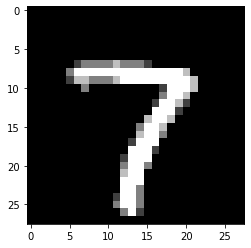

In [13]:
check_mnist(4, pred)

5番目の画像のみ予測が合わなかった

0's pred select9, true is 9
match!
1's pred select1, true is 1
match!
2's pred select7, true is 7
match!
3's pred select7, true is 7
match!
4's pred select7, true is 7
match!
5's pred select5, true is 8
not match!
6's pred select6, true is 6
match!
7's pred select9, true is 9
match!
8's pred select8, true is 8
match!
9's pred select0, true is 0
match!


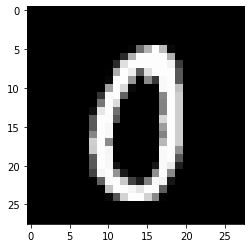

In [14]:
for i in range(10):
  check_mnist(i, pred)

5番目の画像は8,8番目の8は正しく予測出来ているが、8番目の8は8っぽくない。過学習の例と推測される

5's pred select5, true is 8
not match!


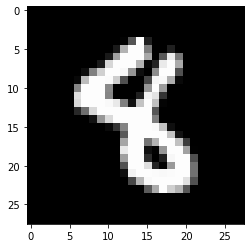

In [15]:
？？check_mnist(5, pred)

8's pred select8, true is 8
match!


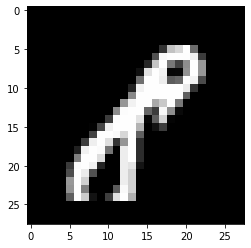

In [16]:
check_mnist(8, pred)